# Starter Notebook

Install and import required libraries

In [ ]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3
!pip install langdetect

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import pickle
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
from transformers import pipeline
import re
import nltk
from nltk.corpus import stopwords

## Load Tokenizer and Preprocess Data

In [ ]:
# Augment training dataset using contextual_augment
nltk.download('punkt_tab')
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Initialize with constants
base_model = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(base_model)
stop_words = set(stopwords.words('english'))

# Text cleaning function
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^\w\s.,!?]', '', text)
    return ' '.join(text.split()).strip()

# Enhanced preprocessing
def preprocess(examples):
    cleaned_texts = [clean_text(text) for text in examples['text']]
    return tokenizer(cleaned_texts, padding='max_length', truncation=True, max_length=128)

# Perform Filtering
def filter_fn(example):
    try:
        # Clean the input text (assumes clean_text handles unwanted characters, HTML, etc.)
        text = clean_text(example['text'])
        # print(text)

        # Skip if the cleaned text is empty
        if not text:
            return False

        # Tokenize the text into words and filter out too short or too long samples
        words = text.split()
        if len(words) < 5 or len(words) > 200:
            return False

        # Compute the ratio of alphabetic characters to total characters (ignore very noisy text)
        alpha_ratio = sum(c.isalpha() for c in text) / max(1, len(text))
        if alpha_ratio < 0.6:
            return False

        # Check if the language is English using langdetect
        if detect(text) != 'en':
            return False
        # Tokenize the text and remove stopwords
        word_tokens = nltk.word_tokenize(text.lower())

        # Ensure enough meaningful content is present (at least 30% non-stopwords)
        meaningful_words = [w for w in word_tokens if w not in stop_words]
        # print(meaningful_words)
        if len(meaningful_words) / max(1, len(word_tokens)) < 0.3:
            return False

        return True
    except:
        return False

# Load and process dataset
dataset = load_dataset('ag_news', split='train')
filtered_dataset = dataset.filter(filter_fn)
tokenized_dataset = filtered_dataset.map(preprocess, batched=True, remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Filter:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/119948 [00:00<?, ? examples/s]

In [ ]:
# dataset = load_dataset('ag_news', split='train')
# filtered_dataset = dataset.filter(filter_fn)
filtered_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 119948
})

In [ ]:
# Extract the number of classess and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

# Create an id2label mapping
# We will need this for our classifier.
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


## Load the Test Data

In [ ]:
import pickle

test_directory = '/content/test_unlabelled.pkl'
# Load the test dataset from .pkl file
with open(test_directory, 'rb') as f:
    test_dataset = pickle.load(f)

tokenized_test = test_dataset.map(preprocess, batched=True, remove_columns=["text"])

print(tokenized_test)
print(type(tokenized_test))

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 8000
})
<class 'datasets.arrow_dataset.Dataset'>


## Load Pre-trained Model
Set up config for pretrained model and download it from hugging face

In [ ]:
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    num_labels=num_labels,
    id2label=id2label)
model

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
# Split the original training set
split_datasets = tokenized_dataset.train_test_split(test_size=640, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

In [ ]:
train_dataset

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 119308
})

In [ ]:
eval_dataset

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 640
})

## Setup LoRA Config
Setup PEFT config and get peft model for finetuning

In [ ]:
# PEFT Config
peft_config = LoraConfig(
    r=9,
    lora_alpha=32,
    lora_dropout=0.1,
    bias = 'none',
    target_modules = ['query', 'value'],
    task_type="SEQ_CLS",
)

In [ ]:
peft_model = get_peft_model(model, peft_config)
peft_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): Mod

In [ ]:
print('PEFT Model')
peft_model.print_trainable_parameters()

PEFT Model
trainable params: 925,444 || all params: 125,574,152 || trainable%: 0.7370


We can see above we have less than 1M parameters

## Training Setup

In [ ]:
# To track evaluation accuracy during training
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [ ]:
# Check if CUDA is available
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")

CUDA available: True
CUDA device count: 1
CUDA device name: Tesla T4


In [ ]:
len(train_dataset)

119308

In [ ]:
# Setup Training args
output_dir = "results"
training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy='steps',
    eval_steps=200,
    logging_strategy="steps",
    logging_steps=200,
    learning_rate=3e-4,
    num_train_epochs=1,
    save_strategy="no",
    weight_decay=0.01,
    lr_scheduler_type="cosine",
    dataloader_num_workers=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    optim="adamw_torch",
    gradient_checkpointing=False,
    gradient_checkpointing_kwargs={'use_reentrant':True},
    report_to="none"
)

def get_trainer(model):
      return  Trainer(
          model=model,
          args=training_args,
          compute_metrics=compute_metrics,
          train_dataset=train_dataset,
          eval_dataset=eval_dataset,
          data_collator=data_collator,
      )

### Start Training

In [ ]:
peft_lora_finetuning_trainer = get_trainer(peft_model)

result = peft_lora_finetuning_trainer.train()

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.248600,0.302620,0.909375,0.911313,0.909375,0.909696
400,0.202900,0.268876,0.915625,0.916636,0.915625,0.915933
600,0.281800,0.239193,0.932813,0.934657,0.932813,0.932690
800,0.274300,0.223847,0.928125,0.929828,0.928125,0.928261
1000,0.258600,0.219016,0.931250,0.931594,0.931250,0.931273
1200,0.274700,0.234798,0.921875,0.923283,0.921875,0.921795
1400,0.240100,0.260638,0.918750,0.921716,0.918750,0.918922
1600,0.259300,0.227416,0.915625,0.918516,0.915625,0.915864
1800,0.235500,0.224670,0.926562,0.928694,0.926562,0.926978
2000,0.267100,0.206541,0.928125,0.928651,0.928125,0.928039


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: T

## Evaluate Finetuned Model
### Run Inference on eval_dataset

In [ ]:
# Evaluate on the validation set

eval_results = peft_lora_finetuning_trainer.evaluate()
print(f"Evaluation results: {eval_results}")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Evaluation results: {'eval_loss': 0.1886601448059082, 'eval_accuracy': 0.93125, 'eval_precision': 0.9313730347081954, 'eval_recall': 0.93125, 'eval_f1': 0.9312376665805839, 'eval_runtime': 4.4288, 'eval_samples_per_second': 144.508, 'eval_steps_per_second': 2.258, 'epoch': 1.0}


In [ ]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
                         If False, only predictions will be returned.
        batch_size (int): Batch size for inference.
        data_collator: Function to collate batches. If None, the default collate_fn is used.

    Returns:
        If labelled is True, returns a tuple (metrics, predictions)
        If labelled is False, returns the predictions.
    """
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')

    # Loop over the DataLoader
    for batch in tqdm(eval_dataloader):
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())

        if labelled:
            # Expecting that labels are provided under the "labels" key.
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )

    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric:", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions

### Run Inference on unlabelled dataset

In [ ]:
# Run inference and save predictions
preds = evaluate_model(peft_model, tokenized_test, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})
df_output.to_csv(os.path.join(output_dir,"submission.csv"), index=False)
print("Inference complete. Predictions saved to submission.csv")

100%|██████████| 1000/1000 [00:53<00:00, 18.72it/s]

Inference complete. Predictions saved to submission.csv


In [ ]:
train_losses = {}
val_losses = {}

for log in peft_lora_finetuning_trainer.state.log_history:
    if 'loss' in log and 'eval_loss' not in log:
        epoch = log.get('epoch', None)
        if epoch is not None:
            train_losses[epoch] = log['loss']
    elif 'eval_loss' in log:
        epoch = log.get('epoch', None)
        if epoch is not None:
            val_losses[epoch] = log['eval_loss']

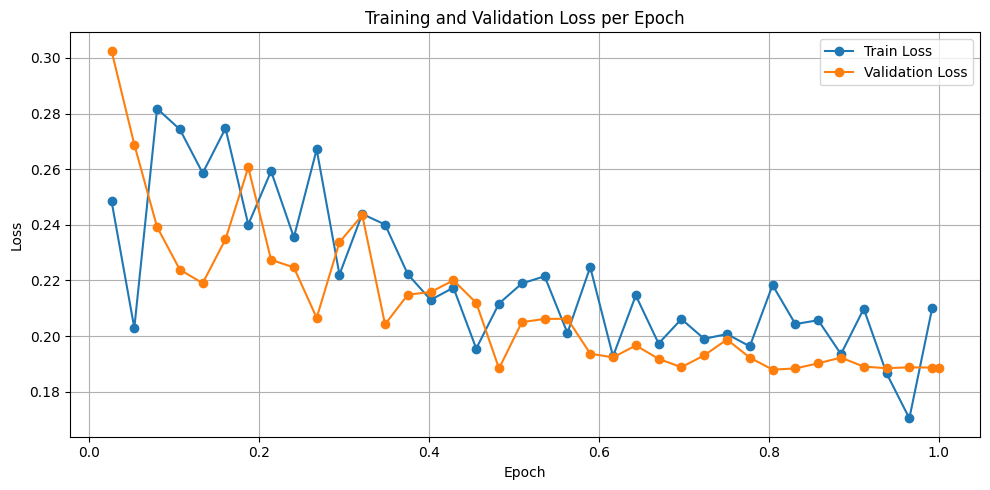

In [ ]:
import matplotlib.pyplot as plt

# Sort by epoch
epochs = sorted(set(train_losses.keys()).union(val_losses.keys()))
train_loss_values = [train_losses.get(epoch, None) for epoch in epochs]
val_loss_values = [val_losses.get(epoch, None) for epoch in epochs]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_values, label='Train Loss', marker='o')
plt.plot(epochs, val_loss_values, label='Validation Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

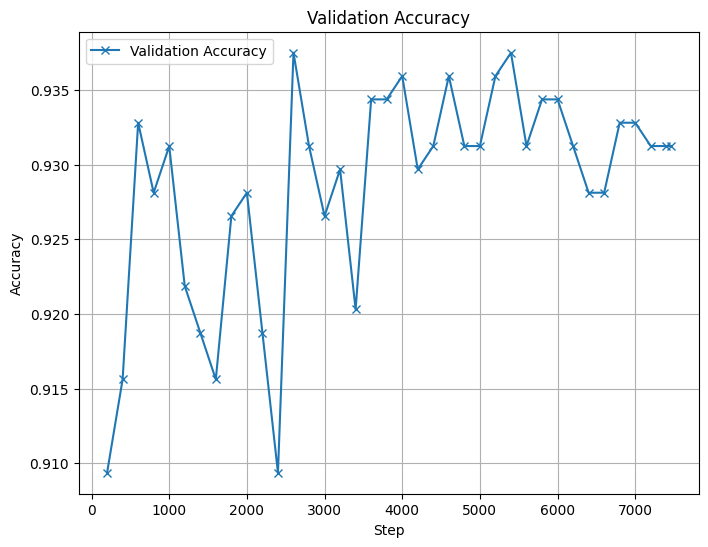

In [ ]:

val_accuracy_steps = []
val_accuracy = []

for entry in peft_lora_finetuning_trainer.state.log_history:

    if "eval_accuracy" in entry:
        val_accuracy_steps.append(entry["step"])
        val_accuracy.append(entry["eval_accuracy"])

plt.figure(figsize=(8, 6))
plt.plot(val_accuracy_steps, val_accuracy, label="Validation Accuracy", marker='x')
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()